1. Implement L2 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).
a. L2 regularization using optimizer’s weight decay
b. L2 regularization using loop to find L2 norm of weights

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models import alexnet,AlexNet_Weights
from torch.utils.data import Dataset,DataLoader,default_collate

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip
!pip install torchinfo

--2024-03-04 18:39:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.0MB/s    in 3.9s    

2024-03-04 18:39:18 (16.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.212

In [3]:
weights = AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [4]:
def custom_collate(batch):
    max_height = max(sample[0].shape[1] for sample in batch)
    max_width = max(sample[0].shape[2] for sample in batch)

    padded_batch = []
    for sample in batch:
        input_data, target = sample
        pad_height = max_height - input_data.shape[1]
        pad_width = max_width - input_data.shape[2]
        padded_input_data = torch.nn.functional.pad(input_data, (0, pad_width, 0, pad_height))
        padded_batch.append((padded_input_data, target))

    return default_collate(padded_batch)


In [5]:
train_dataset = ImageFolder(root='/content/cats_and_dogs_filtered/train',transform=ToTensor(),target_transform=None)
test_dataset = ImageFolder(root='/content/cats_and_dogs_filtered/validation',transform=ToTensor())
train_loader = DataLoader(dataset = train_dataset,batch_size = 32,shuffle=True,collate_fn=custom_collate)
test_loader = DataLoader(dataset = test_dataset,batch_size = 32,collate_fn=custom_collate)
class_names = train_dataset.classes
print(f"Number of classes:{len(class_names)}")

Number of classes:2


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
model = alexnet(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 141MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     23,296               True
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    307,392              True
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6)     

In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
output_shape = len(class_names)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features,output_shape,bias=True)).to(device)

In [11]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

Part a Pytorch's inbuild weight decay parameter in optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)

In [13]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [14]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.4087 | Train Accuracy: 0.8085
Test Loss: 0.2712 | Test Accuracy: 0.8789
Epoch 1:------
Train Loss: 0.3001 | Train Accuracy: 0.8656
Test Loss: 0.2508 | Test Accuracy: 0.8906
Epoch 2:------
Train Loss: 0.2745 | Train Accuracy: 0.8770
Test Loss: 0.2423 | Test Accuracy: 0.8955
Epoch 3:------
Train Loss: 0.2639 | Train Accuracy: 0.8844
Test Loss: 0.2446 | Test Accuracy: 0.8955
Epoch 4:------
Train Loss: 0.2564 | Train Accuracy: 0.8889
Test Loss: 0.2181 | Test Accuracy: 0.9062


Part b manually performing L2 regularization

In [15]:
manual_optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [16]:
lambda_ = 0.001
epochs = 5

In [17]:
def manual_train_step(model, dataloader, loss_fn, optimizer, device, lambda_):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)

        l2_reg = 0.0
        for param in model.parameters():
            l2_reg = torch.norm(param,p=2)**2

        loss += 0.5*lambda_*l2_reg
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def manual_test_step(model,dataloader,loss_fn,device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [18]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    manual_train_step(model,train_loader,loss_fn,manual_optimizer,device,lambda_)
    manual_test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.5581 | Train Accuracy: 0.8348
Test Loss: 0.9503 | Test Accuracy: 0.7773
Epoch 1:------
Train Loss: 0.5591 | Train Accuracy: 0.8626
Test Loss: 0.4131 | Test Accuracy: 0.8711
Epoch 2:------
Train Loss: 0.6197 | Train Accuracy: 0.8502
Test Loss: 0.3471 | Test Accuracy: 0.9014
Epoch 3:------
Train Loss: 0.5397 | Train Accuracy: 0.8725
Test Loss: 0.3123 | Test Accuracy: 0.8994
Epoch 4:------
Train Loss: 0.4979 | Train Accuracy: 0.8760
Test Loss: 0.3075 | Test Accuracy: 0.9111


In [19]:
from PIL import Image
import matplotlib.pyplot as plt

def pred_and_plot_image(model, image_path, class_names, device='cuda'):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    model.to(device)
    model.eval()
    with torch.no_grad():
        transformed_image = transform(img).unsqueeze(dim=0).to(device)
        target_image_pred = model(transformed_image)

        predicted_class_index = torch.argmax(target_image_pred, dim=1).item()
        predicted_class = class_names[predicted_class_index]

        plt.imshow(img)
        plt.title(f"Predicted class: {predicted_class}")
        plt.axis('off')
        plt.show()

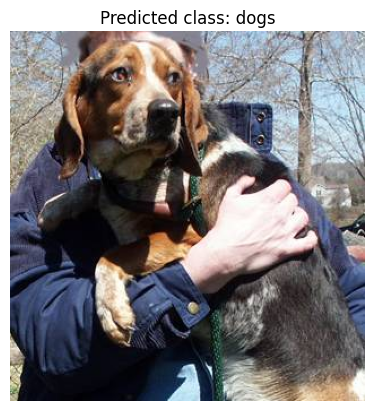

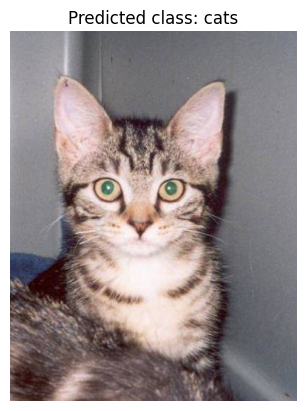

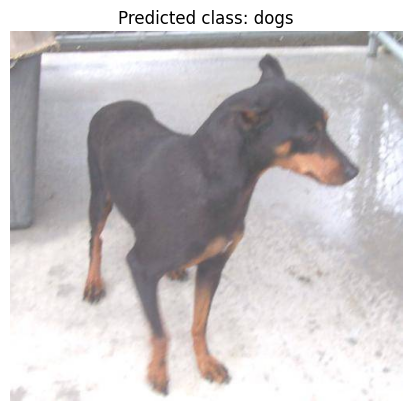

In [21]:
import random
from pathlib import Path
num = 3
test_path = Path('/content/cats_and_dogs_filtered/validation')
test_path_list = list(test_path.glob("*/*.jpg"))
test_image_sample =  random.sample(population=test_path_list,
                               k=num)
for image_path in test_image_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names = class_names)

2. Implement L1 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).
a. L1 regularization using optimizer’s weight decay
b. L1regularization using loop to find L1 norm of weights

Part a L1 regularization using optimizer’s weight decay

In [22]:
l1_optimizer = torch.optim.Adam(params = model.parameters(),lr=0.01,weight_decay=0.01)

In [23]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,l1_optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.5216 | Train Accuracy: 0.8760
Test Loss: 0.3467 | Test Accuracy: 0.8984
Epoch 1:------
Train Loss: 0.5903 | Train Accuracy: 0.8557
Test Loss: 0.5823 | Test Accuracy: 0.8525
Epoch 2:------
Train Loss: 0.6466 | Train Accuracy: 0.8517
Test Loss: 0.5639 | Test Accuracy: 0.8604
Epoch 3:------
Train Loss: 0.4411 | Train Accuracy: 0.8805
Test Loss: 0.3222 | Test Accuracy: 0.8945
Epoch 4:------
Train Loss: 0.4569 | Train Accuracy: 0.8636
Test Loss: 0.4140 | Test Accuracy: 0.8643


Part b L1 regularization using loop to find L1 norm of weights

In [24]:
def manual_train_step(model, dataloader, loss_fn, optimizer, device, lambda_):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)

        l1_reg = 0.0
        for param in model.parameters():
            l1_reg = torch.norm(param,p=1)**2

        loss += 0.5*lambda_*l1_reg
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def manual_test_step(model,dataloader,loss_fn,device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [25]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,manual_optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.4570 | Train Accuracy: 0.8760
Test Loss: 0.3805 | Test Accuracy: 0.8857
Epoch 1:------
Train Loss: 0.6131 | Train Accuracy: 0.8532
Test Loss: 0.6209 | Test Accuracy: 0.8535
Epoch 2:------
Train Loss: 0.8473 | Train Accuracy: 0.8532
Test Loss: 0.6035 | Test Accuracy: 0.8750
Epoch 3:------
Train Loss: 0.4111 | Train Accuracy: 0.9003
Test Loss: 0.4223 | Test Accuracy: 0.8994
Epoch 4:------
Train Loss: 0.4425 | Train Accuracy: 0.8938
Test Loss: 0.3970 | Test Accuracy: 0.9014


3. Implement dropout regularization on cat-dog classification neural network. Train the model with and without dropout on a dataset, and compare the performance and overfitting tendencies.

In [62]:
class CatDogClf(nn.Module):
    def __init__(self, model, dropout_prob=0.0):
        super().__init__()
        self.alexnet = model
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.alexnet(x)
        return x


alexnet_model = alexnet(weights= AlexNet_Weights.DEFAULT)


auto_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_data = ImageFolder(root='/content/cats_and_dogs_filtered/train', transform=auto_transform)
test_data = ImageFolder(root='/content/cats_and_dogs_filtered/validation', transform=auto_transform)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32)

model = CatDogClf(alexnet_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()

In [48]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CatDogClf (CatDogClf)                              [32, 3, 224, 224]    --                   --                   Partial
├─CatDogClf (alexnet)                              [32, 3, 224, 224]    --                   --                   Partial
│    └─CatDogClf (alexnet)                         [32, 3, 224, 224]    --                   --                   Partial
│    │    └─AlexNet (alexnet)                      [32, 3, 224, 224]    [32, 2]              57,012,034           Partial
Total params: 57,012,034
Trainable params: 8,194
Non-trainable params: 57,003,840
Total mult-adds (G): 22.74
Input size (MB): 19.27
Forward/backward pass size (MB): 126.26
Params size (MB): 228.05
Estimated Total Size (MB): 373.57

In [63]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()

In [64]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    #print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    return train_loss,train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        #print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        return test_loss,test_acc

In [71]:
def train_dropout(model, train_loader, test_loader, loss_fn, optimizer, device, dropout_prob=0.5):
    num_epochs = 5
    model.to(device)
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    for epoch in range(num_epochs):
        if dropout_prob > 0:
            print(f"Epoch:{epoch}---- Dropout Applied")
        else:
            print(f"Epoch:{epoch}---- No Dropout Applied")
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Train Loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    return train_losses, train_accs, test_losses, test_accs

def train_no_dropout(model, train_loader, test_loader, loss_fn, optimizer, device, dropout_prob=0):
    print("No Dropout Applied")
    return train_dropout(model, train_loader, test_loader, loss_fn, optimizer, device, dropout_prob=0)


In [72]:
torch.manual_seed(42)
train_losses, train_accs, test_losses, test_accs = train_dropout(model, train_loader, test_loader, loss_fn, optimizer, device)
ndp_train_losses, ndp_train_accs, ndp_test_losses, ndp_test_accs = train_no_dropout(model, train_loader, test_loader, loss_fn, optimizer, device)


Epoch:0---- Dropout Applied
Train Loss: 0.7019 | Train accuracy: 0.4911
Test Loss: 0.6930 | Test accuracy: 0.5117
Epoch:1---- Dropout Applied
Train Loss: 0.7054 | Train accuracy: 0.4861
Test Loss: 0.6991 | Test accuracy: 0.4883
Epoch:2---- Dropout Applied
Train Loss: 0.6996 | Train accuracy: 0.5045
Test Loss: 0.6935 | Test accuracy: 0.4883
Epoch:3---- Dropout Applied
Train Loss: 0.7067 | Train accuracy: 0.5055
Test Loss: 0.6989 | Test accuracy: 0.5117
Epoch:4---- Dropout Applied
Train Loss: 0.6966 | Train accuracy: 0.4955
Test Loss: 0.6953 | Test accuracy: 0.4883
No Dropout Applied
Epoch:0---- No Dropout Applied
Train Loss: 0.6985 | Train accuracy: 0.5084
Test Loss: 0.7195 | Test accuracy: 0.4883
Epoch:1---- No Dropout Applied
Train Loss: 0.7000 | Train accuracy: 0.4881
Test Loss: 0.7176 | Test accuracy: 0.4883
Epoch:2---- No Dropout Applied
Train Loss: 0.6979 | Train accuracy: 0.4965
Test Loss: 0.6967 | Test accuracy: 0.4883
Epoch:3---- No Dropout Applied
Train Loss: 0.6978 | Train ac

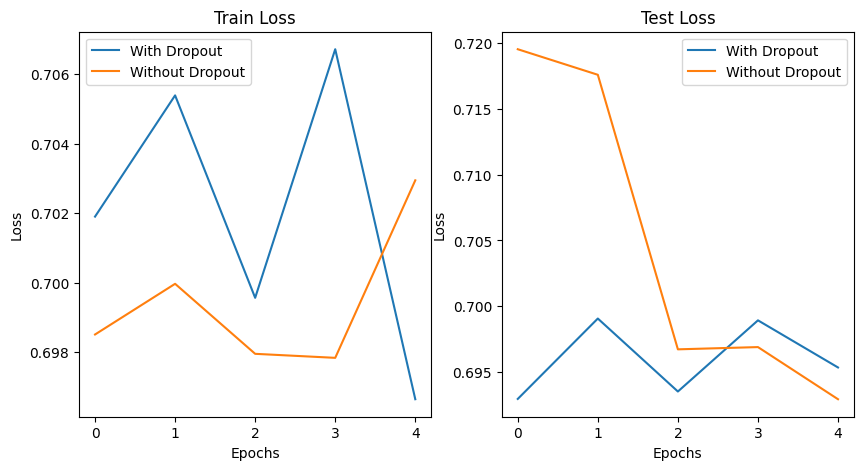

In [75]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0,5), train_losses, label='With Dropout')
plt.plot(range(0,5), ndp_train_losses, label='Without Dropout')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0,5), test_losses, label='With Dropout')
plt.plot(range(0,5), ndp_test_losses, label='Without Dropout')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4. Implement your own version of the dropout layer by using Bernoulli distribution and compare the performance with the library.

In [76]:
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super(CustomDropout, self).__init__()
        self.p = p

    def forward(self, x):
        if not self.training:
            return x
        mask = torch.empty_like(x).bernoulli_(1 - self.p)
        return x * mask / (1 - self.p)

class NetWithCustomDropout(nn.Module):
    def __init__(self):
        super(NetWithCustomDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = CustomDropout()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class NetWithLibraryDropout(nn.Module):
    def __init__(self):
        super(NetWithLibraryDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [77]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 9912422/9912422 [00:00<00:00, 443867223.72it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39807983.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 109159217.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16240859.99it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [78]:
torch.manual_seed(42)
custom_model = NetWithCustomDropout().to(device)
default_model = NetWithLibraryDropout().to(device)

In [81]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    if 'Custom' in model.__class__.__name__:
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} (Custom Dropout)")
    else:
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        if 'Custom' in model.__class__.__name__:
            print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} (Custom Dropout)")
        else:
            print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


In [82]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch:{epoch}----")
    train_step(custom_model,train_loader,loss_fn,optimizer,device)
    test_step(custom_model,test_loader,loss_fn,device)
    train_step(default_model,test_loader,loss_fn,optimizer,device)
    test_step(default_model,test_loader,loss_fn,device)


Epoch:0----
Train Loss: 2.3209 | Train Accuracy: 0.1015 (Custom Dropout)
Test Loss: 2.3057 | Test Accuracy: 0.1120 (Custom Dropout)
Train Loss: 2.3300 | Train Accuracy: 0.0917
Test Loss: 2.3217 | Test Accuracy: 0.0727
Epoch:1----
Train Loss: 2.3192 | Train Accuracy: 0.1024 (Custom Dropout)
Test Loss: 2.3057 | Test Accuracy: 0.1120 (Custom Dropout)
Train Loss: 2.3302 | Train Accuracy: 0.0922
Test Loss: 2.3217 | Test Accuracy: 0.0727
Epoch:2----
Train Loss: 2.3216 | Train Accuracy: 0.1009 (Custom Dropout)
Test Loss: 2.3057 | Test Accuracy: 0.1120 (Custom Dropout)
Train Loss: 2.3296 | Train Accuracy: 0.0893
Test Loss: 2.3217 | Test Accuracy: 0.0727
Epoch:3----
Train Loss: 2.3208 | Train Accuracy: 0.1003 (Custom Dropout)
Test Loss: 2.3057 | Test Accuracy: 0.1120 (Custom Dropout)
Train Loss: 2.3289 | Train Accuracy: 0.0925
Test Loss: 2.3217 | Test Accuracy: 0.0727
Epoch:4----
Train Loss: 2.3200 | Train Accuracy: 0.1020 (Custom Dropout)
Test Loss: 2.3057 | Test Accuracy: 0.1120 (Custom Dropo

5. Implement early stopping as a form of regularization. Train a neural network and monitor the validation loss. Stop training when the validation loss starts increasing, and compare the performance with a model trained without early stopping

In [84]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {(train_loss / len(train_loader)):.4f}, Validation Loss: {(val_loss / len(test_loader)):.4f}")

    if val_loss > best_val_loss:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping...")
            break
    else:
        best_val_loss = val_loss
        early_stop_counter = 0

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {((100 * correct) / total):.4f}%")


Epoch 1, Train Loss: 0.2899, Validation Loss: 0.1511
Epoch 2, Train Loss: 0.1364, Validation Loss: 0.1310
Epoch 3, Train Loss: 0.1077, Validation Loss: 0.1061
Epoch 4, Train Loss: 0.0873, Validation Loss: 0.0988
Epoch 5, Train Loss: 0.0744, Validation Loss: 0.1018
Epoch 6, Train Loss: 0.0687, Validation Loss: 0.0917
Epoch 7, Train Loss: 0.0598, Validation Loss: 0.0830
Epoch 8, Train Loss: 0.0534, Validation Loss: 0.0969
Epoch 9, Train Loss: 0.0491, Validation Loss: 0.0936
Epoch 10, Train Loss: 0.0447, Validation Loss: 0.0917
Accuracy on test set: 97.8900%
